### Title

A quantitative approach to identifying the most valuable customers for Amazon customer service department

### Author

Yusi Chen

### Date

January 14, 2021

### Presentation

https://github.com/yusi0928/Projects/blob/master/7.%20Presentation%20Amazon%20Reviewer%20Segmentation%20Analysis.pdf

#### Feature definition
• asin - ID of the product, e.g. 0000031852 <br>
• title - name of the product <br>
• price - price in US dollars (at time of crawl) <br>
• imUrl - url of the product <br>
• related - related products (also bought, also viewed, bought together, buy after viewing)<br>
• salesRank - sales rank information<br>
• brand - brand name<br>
• categories - list of categories the product belongs to<br>
• reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B<br>
• asin - ID of the product, e.g. 0000013714<br>
• reviewerName - name of the reviewer<br>
• helpful - helpfulness rating of the review, e.g. 2/<br>
• reviewText - text of the review<br>
• overall - rating of the product<br>
• summary - summary of the review<br>
• unixReviewTime - time of the review (unix time) <br>
• reviewTime - time of the review (raw)<br>

# Explore the dataset

In [1]:
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
from ast import literal_eval
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil import parser
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
%matplotlib inline


In [2]:


amazon=pd.read_csv('/Users/abc/Desktop/Takeaway.com/Transformed dataset via SQL/amazon_sampling.csv',low_memory=False)
amazon.head()

asin           salesRank  \
0  0002726874  {'Books': 1857405}   
1  0002726874  {'Books': 1857405}   
2  0002726874  {'Books': 1857405}   
3  0002726874  {'Books': 1857405}   
4  0002726874  {'Books': 1857405}   

                                               imUrl   categories  \
0  http://ecx.images-amazon.com/images/I/41FRF54J...  [['Books']]   
1  http://ecx.images-amazon.com/images/I/41FRF54J...  [['Books']]   
2  http://ecx.images-amazon.com/images/I/41FRF54J...  [['Books']]   
3  http://ecx.images-amazon.com/images/I/41FRF54J...  [['Books']]   
4  http://ecx.images-amazon.com/images/I/41FRF54J...  [['Books']]   

                                               title  \
0  Quartered Safe Out Here: A Recollection of the...   
1  Quartered Safe Out Here: A Recollection of the...   
2  Quartered Safe Out Here: A Recollection of the...   
3  Quartered Safe Out Here: A Recollection of the...   
4  Quartered Safe Out Here: A Recollection of the...   

                                         description  price  \
0  "There is no doubt that it is one of the great...   9.06   
1  "There is no doubt that it is one of the great...   9.06   
2  "There is no doubt that it is one of the great...   9.06   
3  "There is no doubt that it is one of the great...   9.06   
4  "There is no doubt that it is one of the great...   9.06   

                                             related brand      reviewerID  \
0  {'also_bought': ['0815410220', '1602396566', '...   NaN  A17S1450Y06C86   
1  {'also_bought': ['0815410220', '1602396566', '...   NaN   AI6BUH5TK5ZWT   
2  {'also_bought': ['0815410220', '1602396566', '...   NaN   ABG7PJVVJ3PJW   
3  {'also_bought': ['0815410220', '1602396566', '...   NaN   AZ59R1MUCLLD5   
4  {'also_bought': ['0815410220', '1602396566', '...   NaN  A1RAUVCWYHTQI4   

       asin.1      reviewerName   helpful  \
0  0002726874  Aidan J. McQuade    [5, 6]   
1  0002726874   Amazon Customer    [4, 4]   
2  0002726874   Amazon Customer   [6, 12]   
3  0002726874            Aquila  [46, 46]   
4  0002726874           A. Ross  [14, 15]   

                                          reviewText overall  \
0  Towards the end of his life George McDonald Fr...     4.0   
1  George MacDonald Fraser's memoir of his servic...     5.0   
2  A good firsthand account of a man's experience...     3.0   
3  Fraser's is one of the finest war memoirs I've...     5.0   
4  Before Fraser became well known for his &quot;...     4.0   

                                             summary  unixReviewTime  \
0                       An infantryman/s view of war    1.325549e+09   
1  Simply the Best Personal Memoir of WWII I've r...    1.282867e+09   
2  War story good, social commentary simplistic a...    1.385683e+09   
3                  Sobering, relevant, and important    9.355392e+08   
4                                      One Man's War    1.031789e+09   

    reviewTime  
0   01 3, 2012  
1  08 27, 2010  
2  11 29, 2013  
3  08 25, 1999  
4  09 12, 2002

In [3]:
amazon.shape

(112033, 18)

# Data Preparation

In [4]:
# Drop the column asin.1 as it is a duplicated column 
amazon=amazon.drop('asin.1',axis=1)

In [5]:
amazon.shape

(112033, 17)

In [6]:
amazon.isnull().sum()

asin                  0
salesRank          6651
imUrl                 0
categories            0
title               123
description       96279
price             64691
related             569
brand             86498
reviewerID            0
reviewerName        215
helpful               0
reviewText           15
overall               0
summary               1
unixReviewTime        1
reviewTime            1
dtype: int64

In [7]:
# delect the null rolls that fails to show the important info such as price

amazon.dropna(subset=['price','reviewerName','reviewText','unixReviewTime','reviewTime','title','salesRank','related','summary'],inplace=True)




In [8]:
# Keep description and brand even it is null, as these two columns doesn't affect the basic analysis direction.
amazon.isnull().sum()

asin                  0
salesRank             0
imUrl                 0
categories            0
title                 0
description       31229
price                 0
related               0
brand             19988
reviewerID            0
reviewerName          0
helpful               0
reviewText            0
overall               0
summary               0
unixReviewTime        0
reviewTime            0
dtype: int64

In [9]:
amazon.shape

(41920, 17)

## Handle column [salesRank] through regular expression  

### Extract the product type and create a new column

In [10]:
amazon['salesRank'].value_counts()

{}                     2246
{'Books': 178400}       545
{'Books': 3848138}      435
{'Books': 1332834}      341
{'Books': 33701}        239
                       ... 
{'Clothing': 37305}       4
{'Clothing': 9959}        4
{'Shoes': 1334}           4
{'Clothing': 2921}        3
{'Beauty': 259}           2
Name: salesRank, Length: 2913, dtype: int64

In [11]:
# Create a new column to store the product type



# text = "{'Books': 178400}"
pattern='\'.*?\''

amazon['Type'] = amazon['salesRank'].apply(lambda x: re.findall(pattern,x))
amazon['Type'] = amazon['Type'].apply(lambda x:''.join(x).replace("'", ""))
amazon['Type'] 

0            Books
1            Books
2            Books
3            Books
4            Books
            ...   
112012    Clothing
112013    Clothing
112014    Clothing
112015    Clothing
112016    Clothing
Name: Type, Length: 41920, dtype: object

### Handle null 

In [12]:
amazon['Type'].value_counts()


Clothing                     16896
Jewelry                       5719
Books                         4984
Watches                       4518
                              2246
Shoes                         1745
Sports &amp; Outdoors         1403
Home &amp; Kitchen            1144
Toys & Games                  1143
Patio, Lawn & Garden           479
Health & Personal Care         431
Electronics                    392
Home Improvement               234
Arts, Crafts & Sewing          133
Beauty                         113
Industrial & Scientific         95
Musical Instruments             82
Camera &amp; Photo              79
Kitchen & Dining                55
Cell Phones & Accessories       18
Computers & Accessories          6
Baby                             5
Name: Type, dtype: int64

### Extract product sales ranking and create a new column

In [13]:
# Pandas will recognise a value as null if it is a np.nan object, which will print as NaN in the DataFrame. 
# The missing values are probably empty strings, which Pandas doesn't recognise as null. 
# To fix this, convert the empty strings to np.nan objects using replace(), and then call dropna()on the DataFrame to delete rows with null product type.

 
amazon['Type'].replace('', np.nan, inplace=True) 
amazon.dropna(subset=['Type'], inplace=True)


In [14]:
amazon['Type'].isnull().sum()
amazon['Type'].value_counts()

Clothing                     16896
Jewelry                       5719
Books                         4984
Watches                       4518
Shoes                         1745
Sports &amp; Outdoors         1403
Home &amp; Kitchen            1144
Toys & Games                  1143
Patio, Lawn & Garden           479
Health & Personal Care         431
Electronics                    392
Home Improvement               234
Arts, Crafts & Sewing          133
Beauty                         113
Industrial & Scientific         95
Musical Instruments             82
Camera &amp; Photo              79
Kitchen & Dining                55
Cell Phones & Accessories       18
Computers & Accessories          6
Baby                             5
Name: Type, dtype: int64

In [15]:
# Create a new column to store the product salesRanking number

pattern= '\d+'

amazon['salesRanking'] = amazon['salesRank'].apply(lambda x: re.findall(pattern,x)) 
amazon['salesRanking'] = amazon['salesRanking'].apply(lambda x:''.join(x).replace("'", "")) 
amazon['salesRanking'].value_counts()

178400     545
3848138    435
1332834    341
33701      239
248026     214
          ... 
9959         4
4675         4
65684        4
2921         3
259          2
Name: salesRanking, Length: 2807, dtype: int64

In [16]:
amazon['salesRanking'].isnull().sum()  # check the null value

0

In [17]:
# salesrank has been splited into two extra columns, and Product Categories is the duplicated one with Product type, drop.
amazon=amazon.drop(['salesRank','categories'],axis=1)


## Handle column [helpful]

####  The ‘helpful’ column contains values that look like this ‘[20, 25]’. The first value represents the number of helpful votes, the second represents overall votes. This data is useful, but not in this form, so let’s create some additional columns.

In [18]:


def create_helpful_features():

    # Convert the column data type from string to list
    amazon['helpful']= amazon['helpful'].apply(lambda x:literal_eval(x))  


    # Create helpful votes
    amazon['helpful_votes'] = amazon['helpful'].apply(lambda x: x[0])   


    # Create overall votes
    amazon['overall_votes'] = amazon['helpful'].apply(lambda x: x[1])


    # Create a percent helpful column which just divides the number of helpful votes by overall votes
    amazon['helpful_percent'] = round((amazon['helpful_votes'] / amazon['overall_votes']) * 100) 


    # Create a binary column which states if the review is helpful or not
    # review is helpful =1, review is not helpful =0
    # Thredholds: helpful% > 60%, with minimum 5 overall votes 

    amazon['review is helpful'] = np.where((amazon['helpful_percent'] > 60) & (amazon['overall_votes'] > 5), 1, 0)

    
create_helpful_features()

In [19]:
# Drop column helpful
amazon=amazon.drop(['helpful'],axis=1)


In [20]:
amazon.head()

asin                                              imUrl  \
0  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
1  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
2  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
3  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
4  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   

                                               title  \
0  Quartered Safe Out Here: A Recollection of the...   
1  Quartered Safe Out Here: A Recollection of the...   
2  Quartered Safe Out Here: A Recollection of the...   
3  Quartered Safe Out Here: A Recollection of the...   
4  Quartered Safe Out Here: A Recollection of the...   

                                         description  price  \
0  "There is no doubt that it is one of the great...   9.06   
1  "There is no doubt that it is one of the great...   9.06   
2  "There is no doubt that it is one of the great...   9.06   
3  "There is no doubt that it is one of the great...   9.06   
4  "There is no doubt that it is one of the great...   9.06   

                                             related brand      reviewerID  \
0  {'also_bought': ['0815410220', '1602396566', '...   NaN  A17S1450Y06C86   
1  {'also_bought': ['0815410220', '1602396566', '...   NaN   AI6BUH5TK5ZWT   
2  {'also_bought': ['0815410220', '1602396566', '...   NaN   ABG7PJVVJ3PJW   
3  {'also_bought': ['0815410220', '1602396566', '...   NaN   AZ59R1MUCLLD5   
4  {'also_bought': ['0815410220', '1602396566', '...   NaN  A1RAUVCWYHTQI4   

       reviewerName                                         reviewText  \
0  Aidan J. McQuade  Towards the end of his life George McDonald Fr...   
1   Amazon Customer  George MacDonald Fraser's memoir of his servic...   
2   Amazon Customer  A good firsthand account of a man's experience...   
3            Aquila  Fraser's is one of the finest war memoirs I've...   
4           A. Ross  Before Fraser became well known for his &quot;...   

  overall                                            summary  unixReviewTime  \
0     4.0                       An infantryman/s view of war    1.325549e+09   
1     5.0  Simply the Best Personal Memoir of WWII I've r...    1.282867e+09   
2     3.0  War story good, social commentary simplistic a...    1.385683e+09   
3     5.0                  Sobering, relevant, and important    9.355392e+08   
4     4.0                                      One Man's War    1.031789e+09   

    reviewTime   Type salesRanking  helpful_votes  overall_votes  \
0   01 3, 2012  Books      1857405              5              6   
1  08 27, 2010  Books      1857405              4              4   
2  11 29, 2013  Books      1857405              6             12   
3  08 25, 1999  Books      1857405             46             46   
4  09 12, 2002  Books      1857405             14             15   

   helpful_percent  review is helpful  
0             83.0                  1  
1            100.0                  0  
2             50.0                  0  
3            100.0                  1  
4             93.0                  1

## Handle column [reviewText]

#### Advanced: Natural Language Processing

Since customers express their thoughts and feelings more openly than ever before, sentiment analysis is becoming an essential tool to monitor and understand that sentiment. Automatically analyzing customer feedback, such as opinions in survey responses and social media conversations, allows brands to learn what makes customers happy or frustrated, so that they can tailor products and services to meet their customers’ needs.

#### Basic: Review text classification on texts
The TextBlob package for Python is a convenient way to do a lot of Natural Language Processing (NLP) tasks.

I hypothesized that would be interesting are polarity of the reivew, subjectivity, number of words, number of sentences, words per sentence, and sentence complexity.

The polarity score is a float within the range [-1.0, 1.0]. where -1.0 is very negative sentiment, 1.0 is very positive sentiment

The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

In [21]:
# Test TextBlob library



'''
This tells us that the English phrase “This is a good product although the price is bit high” has a polarity 
of about 0.43, 
meaning it is slightly positive, and a subjectivity of about 0.57, meaning it is fairly subjective.
'''

TextBlob('This is a good product although the price is bit high').sentiment


Sentiment(polarity=0.43, subjectivity=0.5700000000000001)

In [22]:
'''
This tells us that the English phrase “The product was broken after using it for 1 week” has a polarity 
of about -0.4, meaning it is slightly negative, and a subjectivity of about 0.4, meaning it is fairly objective.
'''

TextBlob('The product was broken after using it for 1 week').sentiment


Sentiment(polarity=-0.4, subjectivity=0.4)

#### Create a function to process the review texts

In [23]:

def create_textblob_features():
    from textblob import TextBlob
    amazon['sentiment'] = amazon['reviewText'].apply(lambda x: TextBlob(x).sentiment.polarity)
    amazon['subjectivity'] = amazon['reviewText'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    amazon['len_words'] = amazon['reviewText'].apply(lambda x: len(TextBlob(x).words))
    amazon['len_sentences'] = amazon['reviewText'].apply(lambda x: len(TextBlob(x).sentences))
    amazon['words_per_sentence'] = amazon['len_words'] / amazon['len_sentences']
    amazon['sentence_complexity'] = amazon['reviewText'].apply(lambda x: float(len(set(TextBlob(x).words))) / float(len(TextBlob(x).words)))
    
create_textblob_features()   

In [24]:
amazon.head()

asin                                              imUrl  \
0  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
1  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
2  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
3  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
4  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   

                                               title  \
0  Quartered Safe Out Here: A Recollection of the...   
1  Quartered Safe Out Here: A Recollection of the...   
2  Quartered Safe Out Here: A Recollection of the...   
3  Quartered Safe Out Here: A Recollection of the...   
4  Quartered Safe Out Here: A Recollection of the...   

                                         description  price  \
0  "There is no doubt that it is one of the great...   9.06   
1  "There is no doubt that it is one of the great...   9.06   
2  "There is no doubt that it is one of the great...   9.06   
3  "There is no doubt that it is one of the great...   9.06   
4  "There is no doubt that it is one of the great...   9.06   

                                             related brand      reviewerID  \
0  {'also_bought': ['0815410220', '1602396566', '...   NaN  A17S1450Y06C86   
1  {'also_bought': ['0815410220', '1602396566', '...   NaN   AI6BUH5TK5ZWT   
2  {'also_bought': ['0815410220', '1602396566', '...   NaN   ABG7PJVVJ3PJW   
3  {'also_bought': ['0815410220', '1602396566', '...   NaN   AZ59R1MUCLLD5   
4  {'also_bought': ['0815410220', '1602396566', '...   NaN  A1RAUVCWYHTQI4   

       reviewerName                                         reviewText  ...  \
0  Aidan J. McQuade  Towards the end of his life George McDonald Fr...  ...   
1   Amazon Customer  George MacDonald Fraser's memoir of his servic...  ...   
2   Amazon Customer  A good firsthand account of a man's experience...  ...   
3            Aquila  Fraser's is one of the finest war memoirs I've...  ...   
4           A. Ross  Before Fraser became well known for his &quot;...  ...   

  helpful_votes overall_votes  helpful_percent review is helpful sentiment  \
0             5             6             83.0                 1  0.224087   
1             4             4            100.0                 0  0.207843   
2             6            12             50.0                 0  0.050000   
3            46            46            100.0                 1  0.187057   
4            14            15             93.0                 1  0.234398   

  subjectivity  len_words  len_sentences  words_per_sentence  \
0     0.475873        278              6           46.333333   
1     0.526961        148              5           29.600000   
2     0.388095         81              3           27.000000   
3     0.538565        250             10           25.000000   
4     0.466279        425             13           32.692308   

   sentence_complexity  
0             0.561151  
1             0.682432  
2             0.728395  
3             0.600000  
4             0.595294  

[5 rows x 26 columns]

## Handle column [unixReviewTime]

#### Convert the UNIX time to Date

In [25]:
# UNIX time refers to UTC, as I don't know the timezone of the US customers, I will only use Date, and give up the time.

from datetime import datetime

amazon['reviewDate'] = amazon['unixReviewTime'].apply(lambda x:datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
                                                      
amazon['reviewDate']

0         2012-01-03
1         2010-08-27
2         2013-11-29
3         1999-08-25
4         2002-09-12
             ...    
112012    2013-10-16
112013    2013-06-19
112014    2013-02-02
112015    2013-06-02
112016    2013-10-15
Name: reviewDate, Length: 39674, dtype: object

#### Convert the Date to Day

In [26]:
amazon['reviewDay']=amazon['reviewDate'].apply(lambda x:parser.parse(x).strftime("%A"))

amazon['reviewDay']

0           Tuesday
1            Friday
2            Friday
3         Wednesday
4          Thursday
            ...    
112012    Wednesday
112013    Wednesday
112014     Saturday
112015       Sunday
112016      Tuesday
Name: reviewDay, Length: 39674, dtype: object

In [27]:
# Drop unixReviewTime and reviewTime

amazon=amazon.drop(['unixReviewTime','reviewTime'],axis=1)


In [28]:
amazon.head()

asin                                              imUrl  \
0  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
1  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
2  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
3  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   
4  0002726874  http://ecx.images-amazon.com/images/I/41FRF54J...   

                                               title  \
0  Quartered Safe Out Here: A Recollection of the...   
1  Quartered Safe Out Here: A Recollection of the...   
2  Quartered Safe Out Here: A Recollection of the...   
3  Quartered Safe Out Here: A Recollection of the...   
4  Quartered Safe Out Here: A Recollection of the...   

                                         description  price  \
0  "There is no doubt that it is one of the great...   9.06   
1  "There is no doubt that it is one of the great...   9.06   
2  "There is no doubt that it is one of the great...   9.06   
3  "There is no doubt that it is one of the great...   9.06   
4  "There is no doubt that it is one of the great...   9.06   

                                             related brand      reviewerID  \
0  {'also_bought': ['0815410220', '1602396566', '...   NaN  A17S1450Y06C86   
1  {'also_bought': ['0815410220', '1602396566', '...   NaN   AI6BUH5TK5ZWT   
2  {'also_bought': ['0815410220', '1602396566', '...   NaN   ABG7PJVVJ3PJW   
3  {'also_bought': ['0815410220', '1602396566', '...   NaN   AZ59R1MUCLLD5   
4  {'also_bought': ['0815410220', '1602396566', '...   NaN  A1RAUVCWYHTQI4   

       reviewerName                                         reviewText  ...  \
0  Aidan J. McQuade  Towards the end of his life George McDonald Fr...  ...   
1   Amazon Customer  George MacDonald Fraser's memoir of his servic...  ...   
2   Amazon Customer  A good firsthand account of a man's experience...  ...   
3            Aquila  Fraser's is one of the finest war memoirs I've...  ...   
4           A. Ross  Before Fraser became well known for his &quot;...  ...   

  helpful_percent review is helpful sentiment subjectivity  len_words  \
0            83.0                 1  0.224087     0.475873        278   
1           100.0                 0  0.207843     0.526961        148   
2            50.0                 0  0.050000     0.388095         81   
3           100.0                 1  0.187057     0.538565        250   
4            93.0                 1  0.234398     0.466279        425   

   len_sentences  words_per_sentence  sentence_complexity  reviewDate  \
0              6           46.333333             0.561151  2012-01-03   
1              5           29.600000             0.682432  2010-08-27   
2              3           27.000000             0.728395  2013-11-29   
3             10           25.000000             0.600000  1999-08-25   
4             13           32.692308             0.595294  2002-09-12   

   reviewDay  
0    Tuesday  
1     Friday  
2     Friday  
3  Wednesday  
4   Thursday  

[5 rows x 26 columns]

## Correlation analysis

#### Customer review VS price VS salesRank VS sentiment

In [29]:
# Change the column name to avoid misunderstanding
amazon = amazon.rename(columns = {'overall':'rating'})
amazon.columns

Index(['asin', 'imUrl', 'title', 'description', 'price', 'related', 'brand',
       'reviewerID', 'reviewerName', 'reviewText', 'rating', 'summary', 'Type',
       'salesRanking', 'helpful_votes', 'overall_votes', 'helpful_percent',
       'review is helpful', 'sentiment', 'subjectivity', 'len_words',
       'len_sentences', 'words_per_sentence', 'sentence_complexity',
       'reviewDate', 'reviewDay'],
      dtype='object')

In [30]:
amazon['rating'] = pd.to_numeric(amazon['rating'],errors='coerce')   # convert to numeric
amazon['salesRanking'] = pd.to_numeric(amazon['salesRanking'],errors='coerce')  # convert to numeric

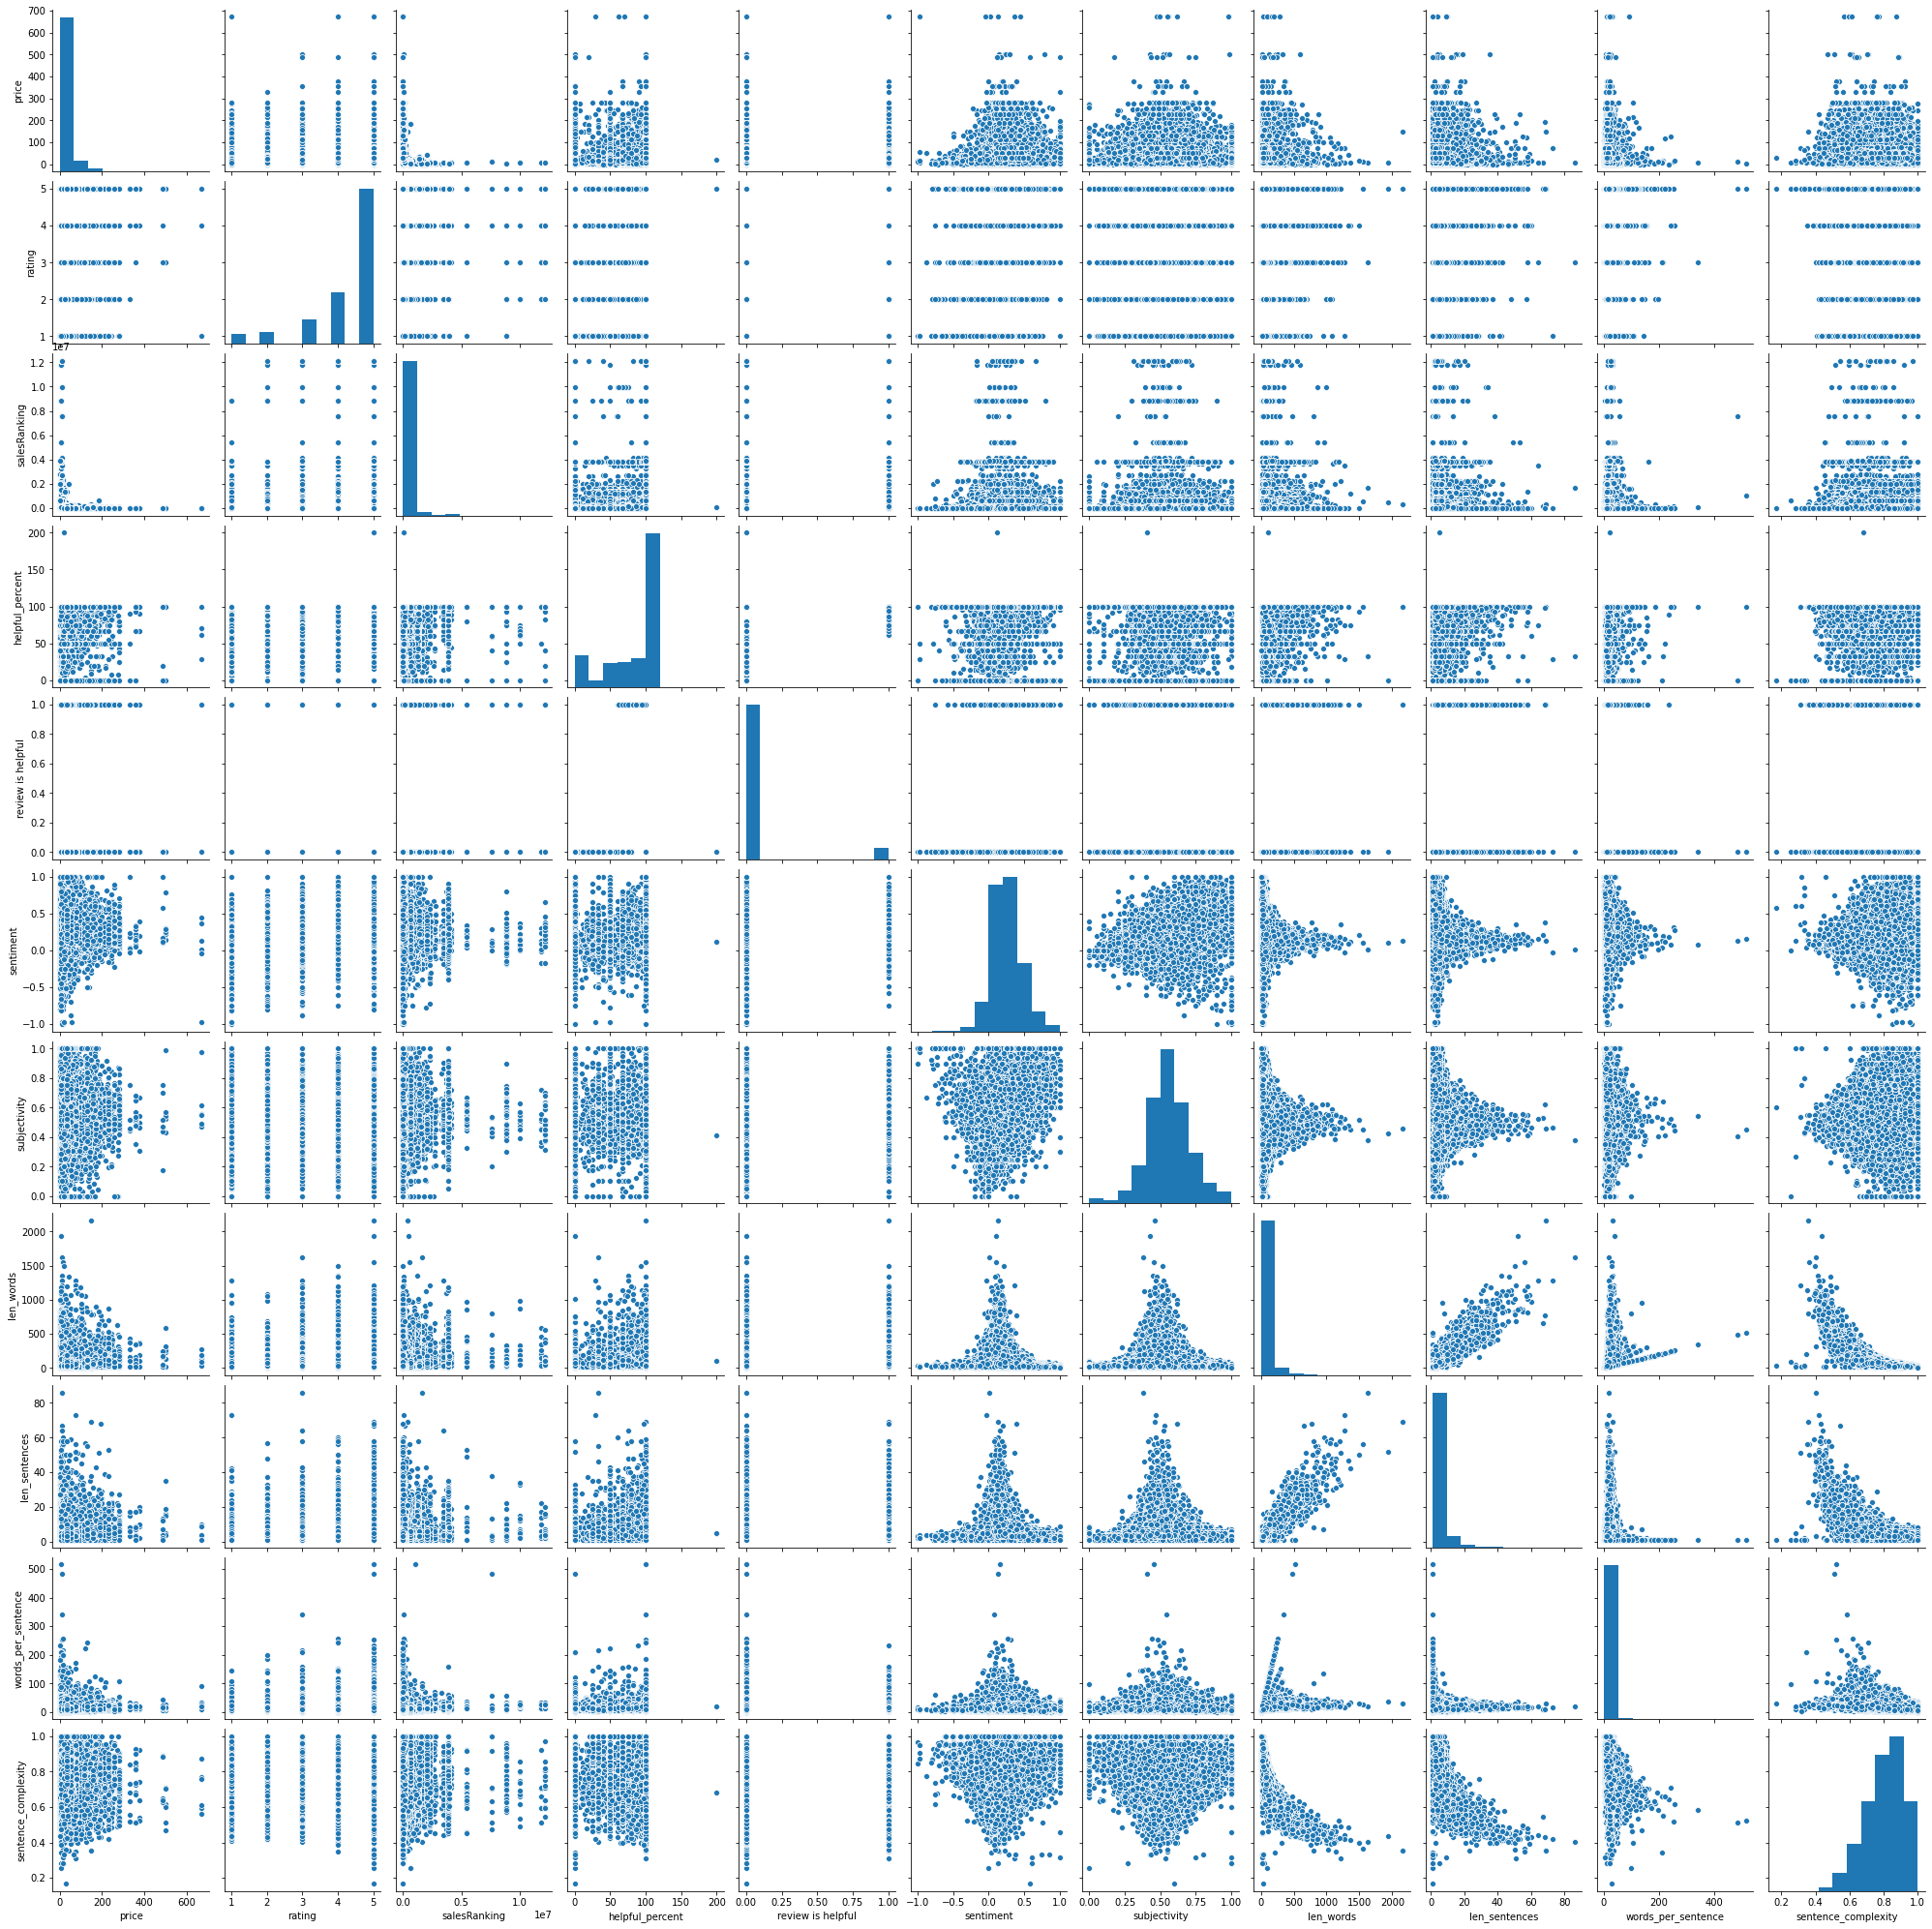

In [31]:
# Plot pair comparison for guaging the data distribution trend against each feature
# For all products aggregated 


pair=amazon[['price','rating','salesRanking','helpful_percent', 
             'review is helpful', 'sentiment', 'subjectivity','len_words', 
             'len_sentences', 'words_per_sentence','sentence_complexity']]

sns.pairplot(pair)


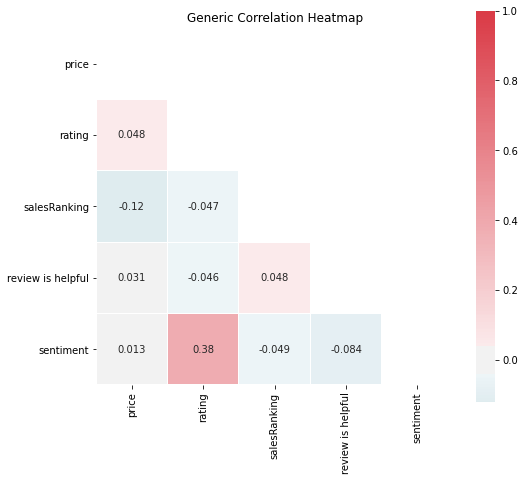

In [32]:
# Compute the correlation matrix for all products


features=list(['price','rating','salesRanking', 'review is helpful', 'sentiment'])


corr_amazon = amazon[features].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_amazon, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 12))
plt.title('Generic Correlation Heatmap')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_amazon, mask=mask, cmap=cmap, vmax=1, center=0,annot=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .6})


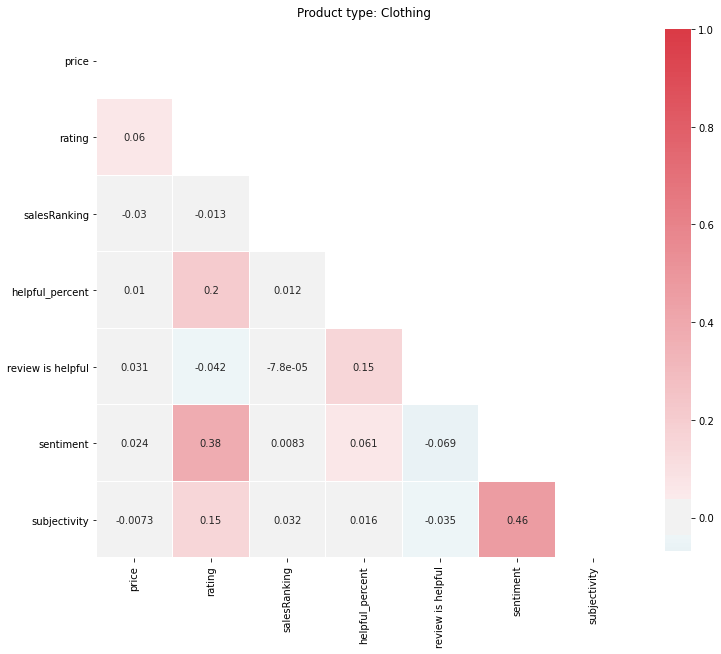

In [33]:
# Compute the correlation matrix for Clothing



df_clothing=amazon.where(amazon['Type'] == 'Clothing')

features=list(['price','rating','salesRanking','helpful_percent', 'review is helpful', 'sentiment', 'subjectivity'])


corr_clothing = df_clothing[features].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_clothing, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 16))
plt.title('Product type: Clothing')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_clothing, mask=mask, cmap=cmap, vmax=1, center=0,annot=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .6})


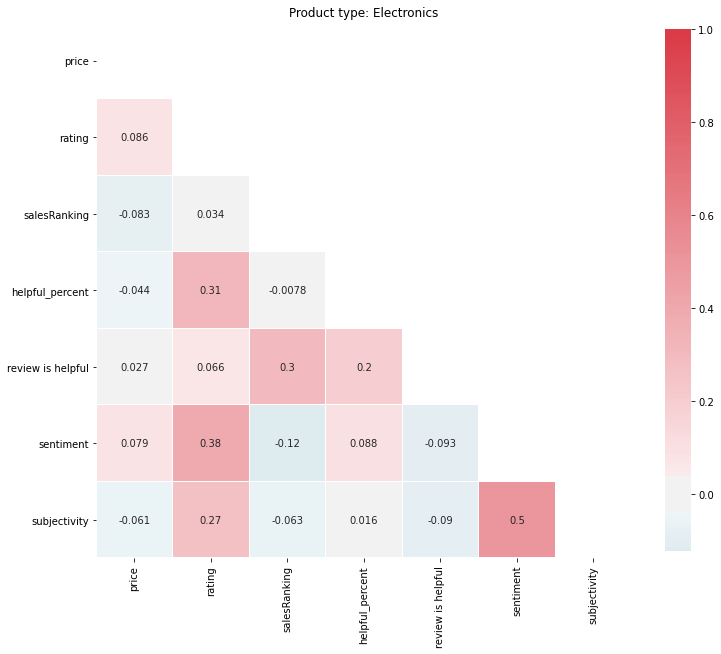

In [34]:
# Compute the correlation matrix for Electronics



df_electronics=amazon.where(amazon['Type'] == 'Electronics')

features=list(['price','rating','salesRanking','helpful_percent', 'review is helpful', 'sentiment', 'subjectivity'])

       #'len_words', 'len_sentences', 'words_per_sentence',
       #'sentence_complexity'])


corr_electronics = df_electronics[features].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_electronics, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 16))
plt.title('Product type: Electronics')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_electronics, mask=mask, cmap=cmap, vmax=1, center=0,annot=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .6})

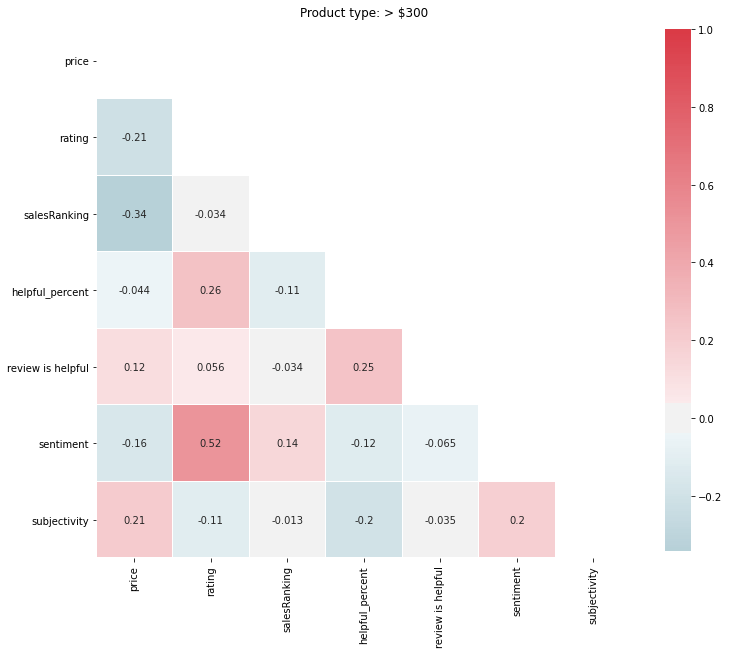

In [35]:
# Compute the correlation matrix for expensive products higher than $ 300




df_expensive=amazon.where(amazon['price'] > 300)

features=list(['price','rating','salesRanking','helpful_percent', 'review is helpful', 'sentiment', 'subjectivity'])

       #'len_words', 'len_sentences', 'words_per_sentence',
       #'sentence_complexity'])


corr_expensive = df_expensive[features].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_expensive, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 16))
plt.title('Product type: > $300')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_expensive, mask=mask, cmap=cmap, vmax=1, center=0,annot=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .6})

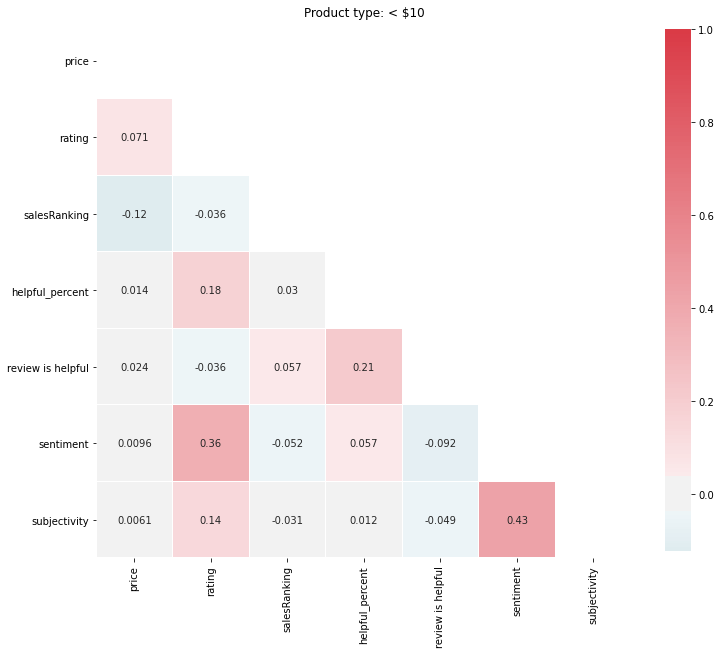

In [36]:
# Compute the correlation matrix for expensive products lower than $ 10


df_cheap=amazon.where(amazon['price'] < 10)

features=list(['price','rating','salesRanking','helpful_percent', 'review is helpful', 'sentiment', 'subjectivity'])

       #'len_words', 'len_sentences', 'words_per_sentence',
       #'sentence_complexity'])


corr_cheap = df_cheap[features].corr()


# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_cheap, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 16))
plt.title('Product type: < $10')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_cheap, mask=mask, cmap=cmap, vmax=1, center=0,annot=True,
            square=True, linewidths=.1, cbar_kws={"shrink": .6})

In [37]:

amazon.to_csv('/Users/abc/Desktop/Takeaway.com/Prepare for Tableau/overall.csv', index=True, header=True)

# Reviewer segmentation 


#### Create a new dataframe as a basis for reveiwer segementation

In [38]:
amazon.columns

Index(['asin', 'imUrl', 'title', 'description', 'price', 'related', 'brand',
       'reviewerID', 'reviewerName', 'reviewText', 'rating', 'summary', 'Type',
       'salesRanking', 'helpful_votes', 'overall_votes', 'helpful_percent',
       'review is helpful', 'sentiment', 'subjectivity', 'len_words',
       'len_sentences', 'words_per_sentence', 'sentence_complexity',
       'reviewDate', 'reviewDay'],
      dtype='object')

In [39]:
review = amazon[['asin','Type','brand','title','price','reviewerID','rating','helpful_percent','overall_votes']]

review.head()

asin   Type brand                                              title  \
0  0002726874  Books   NaN  Quartered Safe Out Here: A Recollection of the...   
1  0002726874  Books   NaN  Quartered Safe Out Here: A Recollection of the...   
2  0002726874  Books   NaN  Quartered Safe Out Here: A Recollection of the...   
3  0002726874  Books   NaN  Quartered Safe Out Here: A Recollection of the...   
4  0002726874  Books   NaN  Quartered Safe Out Here: A Recollection of the...   

   price      reviewerID  rating  helpful_percent  overall_votes  
0   9.06  A17S1450Y06C86     4.0             83.0              6  
1   9.06   AI6BUH5TK5ZWT     5.0            100.0              4  
2   9.06   ABG7PJVVJ3PJW     3.0             50.0             12  
3   9.06   AZ59R1MUCLLD5     5.0            100.0             46  
4   9.06  A1RAUVCWYHTQI4     4.0             93.0             15

In [40]:
review.shape

(39674, 9)

In [41]:
# set a condition to create the new helpful feature
review.isnull().sum()

asin                   0
Type                   0
brand              19713
title                  0
price                  0
reviewerID             0
rating                 1
helpful_percent    25297
overall_votes          0
dtype: int64

In [42]:
# Replace the Null value in column helpful_percent with 0
review['helpful_percent'] = review['helpful_percent'].fillna(0)
review.isnull().sum()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


asin                   0
Type                   0
brand              19713
title                  0
price                  0
reviewerID             0
rating                 1
helpful_percent        0
overall_votes          0
dtype: int64

In [43]:
# Drop null in collumn rating

review.dropna(subset=['rating'],inplace=True)
review.isnull().sum()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


asin                   0
Type                   0
brand              19713
title                  0
price                  0
reviewerID             0
rating                 0
helpful_percent        0
overall_votes          0
dtype: int64

Text(0, 0.5, 'price')

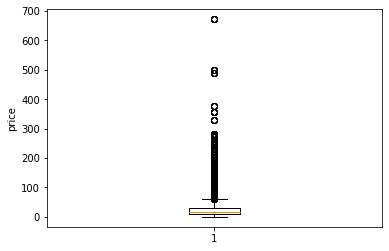

In [44]:
# Explore the outliers

plt.boxplot(review['price'])
plt.ylabel('price')

# It looks like no outliers in column price,good

Text(0, 0.5, 'overall_votes ')

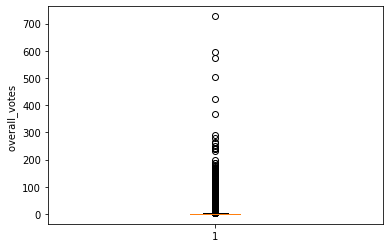

In [45]:
plt.boxplot(review['overall_votes'])
plt.ylabel('overall_votes ')

# It looks like no outliers in column overall_votes, good

In [46]:
segment = review.groupby('reviewerID').agg(Frequency=('asin','count'),
                                          Monetary=('price','sum'),
                                          Satisfaction=('rating','mean'),
                                          Influence=('overall_votes','sum'),
                                          Helpfulness=('helpful_percent','mean')
                                         )
                                          

segment.head()

Frequency  Monetary  Satisfaction  Influence  \
reviewerID                                                            
A001114613O3F18Q5NVR6          1     52.99           5.0          1   
A00338282E99B8OR2JYTZ          1     11.55           3.0          0   
A00354001GE099Q1FL0TU          1     18.02           3.0          0   
A007227915NZZC7B6P030          1      3.99           5.0          0   
A0145698H8AAYMRXLBD8           1     20.25           5.0          0   

                       Helpfulness  
reviewerID                          
A001114613O3F18Q5NVR6        100.0  
A00338282E99B8OR2JYTZ          0.0  
A00354001GE099Q1FL0TU          0.0  
A007227915NZZC7B6P030          0.0  
A0145698H8AAYMRXLBD8           0.0

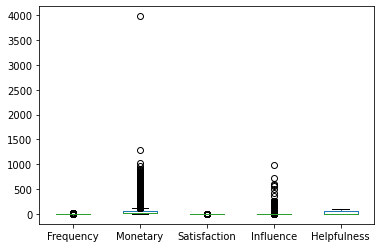

In [47]:
# Boxplot to define outliers
segment.plot(kind='box')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe51a257be0>,
      dtype=object)

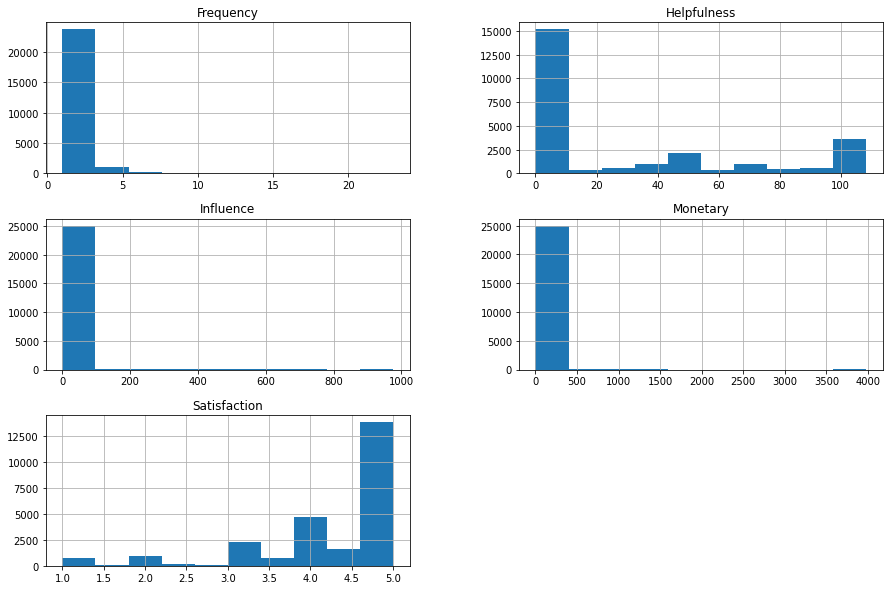

In [48]:
# Plot the histograms for 5 new features

segment.hist(bins=10, figsize=(15,10))


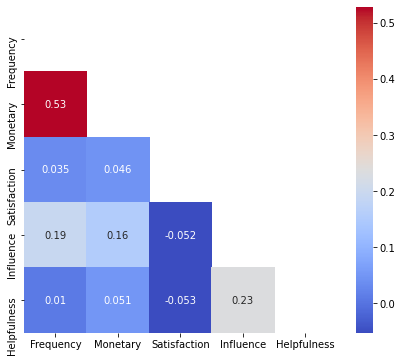

In [49]:
# Collumn collinearity check -any high correlations?

matrix=segment.corr()


plt.figure(figsize=(7,6))
mask=np.triu(matrix)
sns.heatmap(matrix, annot=True, cmap='coolwarm', mask=mask)

plt.show()

# There is no high column collienarity observed, let's keep it as it is. 

In [50]:
segment.to_csv('/Users/abc/Desktop/Takeaway.com/Prepare for Tableau/segment.csv', index=True, header=True)

## Method 1: Using Machine Learning Algorithms to cluster the customers

#### KMeans Algorithem: test the optimal parameter: n_cluster number  


In [51]:
# Feature scaling
# Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling.

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score

scaler=StandardScaler()
segment_scale=scaler.fit_transform(segment)



# Evaluate the silhouette_score for each n_cluster number
for i in range(3,7):
    clusterer = KMeans(n_clusters=i)
    preds = clusterer.fit_predict(segment_scale)
    centers = clusterer.cluster_centers_

    score = silhouette_score(segment_scale, preds)
    print("For n_clusters = {}, silhouette score is {}".format(i, score))
    

print('The silhouette score is the optimal when cluster number is 3, hence the review segment should be divided by 3 clusterings')


For n_clusters = 3, silhouette score is 0.383395049240055
For n_clusters = 4, silhouette score is 0.4171403097043584
For n_clusters = 5, silhouette score is 0.42848888487610803
For n_clusters = 6, silhouette score is 0.43711221943570655
The silhouette score is the optimal when cluster number is 3, hence the review segment should be divided by 3 clusterings


#### Final run of the KMeans algorithem with the optimal clustering number

In [52]:

cluster=KMeans(n_clusters=3)
model=cluster.fit(segment_scale)

segment['Labels']=model.labels_   # Using scaled features to build the model and apply the labels to the original dataset

segment.head()


Frequency  Monetary  Satisfaction  Influence  \
reviewerID                                                            
A001114613O3F18Q5NVR6          1     52.99           5.0          1   
A00338282E99B8OR2JYTZ          1     11.55           3.0          0   
A00354001GE099Q1FL0TU          1     18.02           3.0          0   
A007227915NZZC7B6P030          1      3.99           5.0          0   
A0145698H8AAYMRXLBD8           1     20.25           5.0          0   

                       Helpfulness  Labels  
reviewerID                                  
A001114613O3F18Q5NVR6        100.0       1  
A00338282E99B8OR2JYTZ          0.0       0  
A00354001GE099Q1FL0TU          0.0       0  
A007227915NZZC7B6P030          0.0       0  
A0145698H8AAYMRXLBD8           0.0       0

In [53]:
segment['Labels'].value_counts()

0    14892
1     7250
2     2973
Name: Labels, dtype: int64

In [54]:
segment.head(20)

Frequency  Monetary  Satisfaction  Influence  \
reviewerID                                                            
A001114613O3F18Q5NVR6          1     52.99           5.0          1   
A00338282E99B8OR2JYTZ          1     11.55           3.0          0   
A00354001GE099Q1FL0TU          1     18.02           3.0          0   
A007227915NZZC7B6P030          1      3.99           5.0          0   
A0145698H8AAYMRXLBD8           1     20.25           5.0          0   
A0148968UM59JS3Y8D1M           4     51.33           4.5          0   
A0224041E58B9YLYXLOL           1     21.99           5.0          0   
A02324053VU4N09WNQTBN          1     25.47           4.0          0   
A02755422E9NI29TCQ5W3          1      3.44           3.0          0   
A03355352UQGJRUSZECK9          1      3.99           5.0          0   
A034597326Z83X79S50FI          1     28.03           5.0          0   
A03523552G1P2GZGUZLQ9          1     15.95           5.0          0   
A036147939NFPC389VLK           2    165.96           4.5          3   
A03756272FRRX98COZNG7          2     46.73           5.0          0   
A04095881JK7GJRJYSY4N          1      8.82           5.0          0   
A04774152BAIWDOYB7B4I          1      0.99           4.0          0   
A05306962T0DL4FS2RA7L          1      8.70           5.0          0   
A05613441GM5VUIRSCIK1          1      2.50           4.0          0   
A05817183H8F5BZ7IUE1K          1     24.90           4.0          0   
A0604201MBJEJ93VKB77           1    165.21           5.0          0   

                       Helpfulness  Labels  
reviewerID                                  
A001114613O3F18Q5NVR6        100.0       1  
A00338282E99B8OR2JYTZ          0.0       0  
A00354001GE099Q1FL0TU          0.0       0  
A007227915NZZC7B6P030          0.0       0  
A0145698H8AAYMRXLBD8           0.0       0  
A0148968UM59JS3Y8D1M           0.0       2  
A0224041E58B9YLYXLOL           0.0       0  
A02324053VU4N09WNQTBN          0.0       0  
A02755422E9NI29TCQ5W3          0.0       0  
A03355352UQGJRUSZECK9          0.0       0  
A034597326Z83X79S50FI          0.0       0  
A03523552G1P2GZGUZLQ9          0.0       0  
A036147939NFPC389VLK          50.0       2  
A03756272FRRX98COZNG7          0.0       0  
A04095881JK7GJRJYSY4N          0.0       0  
A04774152BAIWDOYB7B4I          0.0       0  
A05306962T0DL4FS2RA7L          0.0       0  
A05613441GM5VUIRSCIK1          0.0       0  
A05817183H8F5BZ7IUE1K          0.0       0  
A0604201MBJEJ93VKB77           0.0       0

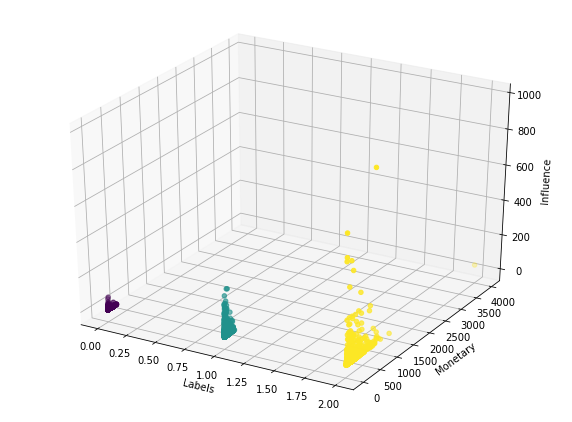

In [55]:
# Visualising the clustering in 3D model

from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(projection='3d')
ax.scatter(zs=segment.Influence, ys=segment.Monetary, xs=segment.Labels, c=segment.Labels)
ax.set_xlabel('Labels')
ax.set_ylabel('Monetary')
ax.set_zlabel('Influence')
plt.show()

## Method 2: Manually conduct customers clustering based on business sense

In [56]:

segment=segment.drop(['Labels'],axis=1)

In [57]:
segment.describe()

Frequency      Monetary  Satisfaction     Influence   Helpfulness
count  25115.000000  25115.000000  25115.000000  25115.000000  25115.000000
mean       1.579654     44.724247      4.285984      3.432252     27.905662
std        1.066541     69.341251      1.003885     16.328645     38.694996
min        1.000000      0.100000      1.000000      0.000000      0.000000
25%        1.000000      9.990000      4.000000      0.000000      0.000000
50%        1.000000     22.230000      5.000000      0.000000      0.000000
75%        2.000000     50.780000      5.000000      2.000000     50.000000
max       23.000000   3980.710000      5.000000    976.000000    108.375000

#### Use qcut to divide the data of the 4 features which distributed unevenly

Qcut represents “Quantile-based discretization function.” Qcut tries to divide up the underlying data into equal sized bins. The function defines the bins using percentiles based on the distribution of the data, not the actual numeric edges of the bins.

In [58]:
bins = [1, 2,3,4,5]

segment['Monetary']=pd.qcut(segment['Monetary'], q=[0, 0.6, 0.75,0.95,0.99, 1],labels=bins)

segment['Helpfulness'] = pd.qcut(segment['Helpfulness'],q=[0, 0.6031,0.6039, 0.65, 0.8,1],labels=bins)

segment['Frequency'] = pd.qcut(segment['Frequency'],q=[0, 0.76, 0.94,0.998,0.9996,1],labels=bins)

segment['Influence']=pd.qcut(segment['Influence'], q=[0, 0.7, 0.75,0.9,0.99, 1],labels=bins)


In [59]:
# Convert the columns to numeric
segment['Frequency'] = pd.to_numeric(segment['Frequency'], downcast="float")
segment['Monetary'] = pd.to_numeric(segment['Monetary'], downcast="float")
segment['Influence'] = pd.to_numeric(segment['Influence'], downcast="float")
segment['Helpfulness'] = pd.to_numeric(segment['Helpfulness'], downcast="float")
segment.dtypes

Frequency       float32
Monetary        float32
Satisfaction    float64
Influence       float32
Helpfulness     float32
dtype: object

In [60]:
# Creating a new column to save the average value of the 5 variables.

segment['AvgScore'] = segment.mean(axis=1,numeric_only=True)

segment.head()

Frequency  Monetary  Satisfaction  Influence  \
reviewerID                                                            
A001114613O3F18Q5NVR6        1.0       3.0           5.0        1.0   
A00338282E99B8OR2JYTZ        1.0       1.0           3.0        1.0   
A00354001GE099Q1FL0TU        1.0       1.0           3.0        1.0   
A007227915NZZC7B6P030        1.0       1.0           5.0        1.0   
A0145698H8AAYMRXLBD8         1.0       1.0           5.0        1.0   

                       Helpfulness  AvgScore  
reviewerID                                    
A001114613O3F18Q5NVR6          5.0       3.0  
A00338282E99B8OR2JYTZ          1.0       1.4  
A00354001GE099Q1FL0TU          1.0       1.4  
A007227915NZZC7B6P030          1.0       1.8  
A0145698H8AAYMRXLBD8           1.0       1.8

In [61]:
# Labelling customers according to their average score.

bins = [0.999, 1.9999, 2.9999, 3.9999, 4.4999, 5.0]
labels = ['1-star', '2-star', '3-star', '4-star', '5-star']

segment['Label'] = pd.cut(segment['AvgScore'], bins=bins, labels=labels)
segment.head()

Frequency  Monetary  Satisfaction  Influence  \
reviewerID                                                            
A001114613O3F18Q5NVR6        1.0       3.0           5.0        1.0   
A00338282E99B8OR2JYTZ        1.0       1.0           3.0        1.0   
A00354001GE099Q1FL0TU        1.0       1.0           3.0        1.0   
A007227915NZZC7B6P030        1.0       1.0           5.0        1.0   
A0145698H8AAYMRXLBD8         1.0       1.0           5.0        1.0   

                       Helpfulness  AvgScore   Label  
reviewerID                                            
A001114613O3F18Q5NVR6          5.0       3.0  3-star  
A00338282E99B8OR2JYTZ          1.0       1.4  1-star  
A00354001GE099Q1FL0TU          1.0       1.4  1-star  
A007227915NZZC7B6P030          1.0       1.8  1-star  
A0145698H8AAYMRXLBD8           1.0       1.8  1-star

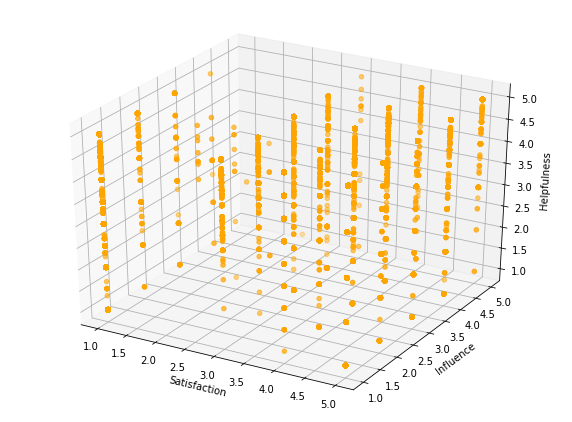

In [62]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10,7.5))
ax = fig.add_subplot(projection='3d')
ax.scatter(zs=segment.Satisfaction, ys=segment.Influence, xs=segment.Helpfulness,c='orange')
ax.set_xlabel('Satisfaction')
ax.set_ylabel('Influence')
ax.set_zlabel('Helpfulness')
plt.show()

### Customer Personas

In [63]:
segment.sort_values(by=['Monetary'], ascending=False)

Frequency  Monetary  Satisfaction  Influence  Helpfulness  \
reviewerID                                                                  
A7NJ6BVT92TJS         2.0       5.0      4.666667        1.0          1.0   
A3JOWXRNYC6UHL        4.0       5.0      4.545455        4.0          4.0   
A7O3870BUEO4K         4.0       5.0      4.333333        1.0          1.0   
A1247LFDYISISU        3.0       5.0      3.000000        3.0          4.0   
A2G4MGVWR20OOI        3.0       5.0      5.000000        2.0          3.0   
...                   ...       ...           ...        ...          ...   
A35WGVT8AUEODN        1.0       1.0      4.000000        1.0          5.0   
A35WQNQID00GBW        1.0       1.0      3.000000        1.0          1.0   
A1URRWRCDRHHWZ        1.0       1.0      5.000000        1.0          1.0   
A1UQYIG1FIIM40        1.0       1.0      5.000000        1.0          1.0   
A2VVHERU17FPKE        1.0       1.0      5.000000        1.0          1.0   

                AvgScore   Label  
reviewerID                        
A7NJ6BVT92TJS   2.733333  2-star  
A3JOWXRNYC6UHL  4.309091  4-star  
A7O3870BUEO4K   3.066667  3-star  
A1247LFDYISISU  3.600000  3-star  
A2G4MGVWR20OOI  3.600000  3-star  
...                  ...     ...  
A35WGVT8AUEODN  2.400000  2-star  
A35WQNQID00GBW  1.400000  1-star  
A1URRWRCDRHHWZ  1.800000  1-star  
A1UQYIG1FIIM40  1.800000  1-star  
A2VVHERU17FPKE  1.800000  1-star  

[25115 rows x 7 columns]

#### Persona 1

In [64]:
###################### Persona 3-star customer ###################



import plotly.graph_objects as go

fig = go.Figure(data=go.Scatterpolar(
  r=[2,5,4.666667,1,1],
  theta=['Frequency','Monetary','Satisfaction','Influence','Helpfulness'],
  fill='toself'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

'''
Customer persona 1:

reviewerID: A7NJ6BVT92TJS
reviwer Name: BertLovesErnie

Although not shop very often, Bert spent a lot to buy the product on Amazon, and he is a happy customer.
Micheal don't often write reviews and his review is not influencial among posible customers
'''

"\nCustomer persona 1:\n\nreviewerID: A7NJ6BVT92TJS\nreviwer Name: BertLovesErnie\n\nAlthough not shop very often, Micheal spent a lot to buy the product on Amazon, and he is a happy customer.\nMicheal don't often write reviews and his review is not influencial among posible customers\n"

In [65]:
segment.sort_values(by=['Frequency'], ascending=False)[:10]

Frequency  Monetary  Satisfaction  Influence  Helpfulness  \
reviewerID                                                                  
A2R6RA8FRBS608        5.0       5.0      4.800000        5.0          5.0   
AFVQZQ8PW0L           5.0       3.0      4.777778        5.0          4.0   
A3W4D8XOGLWUN5        5.0       5.0      3.826087        4.0          4.0   
A8VI7KMUHI7ZH         5.0       5.0      5.000000        2.0          3.0   
A2GA55P7WGHJCP        5.0       4.0      4.066667        4.0          4.0   
A132ETQPMHQ585        5.0       4.0      4.800000        3.0          3.0   
AJGU56YG8G1DQ         5.0       3.0      5.000000        4.0          3.0   
A3977M5S0GIG5H        5.0       5.0      4.800000        5.0          5.0   
A260QLS8Z33KCQ        4.0       5.0      4.555556        3.0          3.0   
A2KBV88FL48CFS        4.0       4.0      4.583333        5.0          5.0   

                AvgScore   Label  
reviewerID                        
A2R6RA8FRBS608  4.960000  5-star  
AFVQZQ8PW0L     4.355556  4-star  
A3W4D8XOGLWUN5  4.365217  4-star  
A8VI7KMUHI7ZH   4.000000  4-star  
A2GA55P7WGHJCP  4.213333  4-star  
A132ETQPMHQ585  3.960000  3-star  
AJGU56YG8G1DQ   4.000000  4-star  
A3977M5S0GIG5H  4.960000  5-star  
A260QLS8Z33KCQ  3.911111  3-star  
A2KBV88FL48CFS  4.516667  5-star

In [66]:
###################### Persona 5-star customer ###################

import plotly.graph_objects as go

fig = go.Figure(data=go.Scatterpolar(
  r=[5,5,4.8,5,5],
  theta=['Frequency','Monetary','Satisfaction','Influence','Helpfulness'],
  fill='toself'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

'''
Customer persona 2:

reviewer ID:A2R6RA8FRBS608
reviewer Name: Matthew G. Sherwin

'''

"\nCustomer persona 2:\n\nreviewer ID:A2R6RA8FRBS608\nreviewer Name: Matthew G. Sherwin\n\nAlthough not shop very often, Micheal spent a lot to buy the product on Amazon, and he is a happy customer.\nMicheal don't often write reviews and his review is not influencial among posible customers\n"

#### Persona 3

In [67]:
segment.sort_values(by=['Helpfulness'], ascending=False)[:20]

Frequency  Monetary  Satisfaction  Influence  \
reviewerID                                                            
A001114613O3F18Q5NVR6        1.0       3.0           5.0        1.0   
A24PJ2I90DB3M8               1.0       3.0           4.5        5.0   
AB6HEXPVLXFSO                1.0       1.0           5.0        3.0   
AB70CCTCKXMPV                1.0       1.0           5.0        3.0   
A24WONV4WEHZ6S               1.0       3.0           5.0        2.0   
A24WBL7L2I13VK               1.0       3.0           5.0        3.0   
A24US7853WVRZZ               1.0       1.0           5.0        1.0   
A24UJFD6O4QWD8               1.0       1.0           5.0        1.0   
AB8T7H13662O9                1.0       3.0           5.0        1.0   
A24SSGVET9JP21               1.0       1.0           3.0        1.0   
A24RY9PES5O6Q                1.0       3.0           4.0        3.0   
ABCNNP742AV30                1.0       1.0           4.0        4.0   
A24PNVO7VEPW6                1.0       3.0           5.0        1.0   
A24PNVLQKEOZ2N               1.0       1.0           1.0        1.0   
ABD7HPJOBC8BJ                1.0       1.0           1.0        3.0   
A24YIQ3LFEVHDY               1.0       3.0           5.0        3.0   
ABD7JNA9U7VX7                1.0       1.0           1.0        4.0   
A24N31BU7GPKIP               1.0       2.0           1.0        1.0   
A24MWT099UWNWG               3.0       5.0           2.6        4.0   
A24MAK5PWLH6KQ               1.0       4.0           5.0        3.0   

                       Helpfulness  AvgScore   Label  
reviewerID                                            
A001114613O3F18Q5NVR6          5.0      3.00  3-star  
A24PJ2I90DB3M8                 5.0      3.70  3-star  
AB6HEXPVLXFSO                  5.0      3.00  3-star  
AB70CCTCKXMPV                  5.0      3.00  3-star  
A24WONV4WEHZ6S                 5.0      3.20  3-star  
A24WBL7L2I13VK                 5.0      3.40  3-star  
A24US7853WVRZZ                 5.0      2.60  2-star  
A24UJFD6O4QWD8                 5.0      2.60  2-star  
AB8T7H13662O9                  5.0      3.00  3-star  
A24SSGVET9JP21                 5.0      2.20  2-star  
A24RY9PES5O6Q                  5.0      3.20  3-star  
ABCNNP742AV30                  5.0      3.00  3-star  
A24PNVO7VEPW6                  5.0      3.00  3-star  
A24PNVLQKEOZ2N                 5.0      1.80  1-star  
ABD7HPJOBC8BJ                  5.0      2.20  2-star  
A24YIQ3LFEVHDY                 5.0      3.40  3-star  
ABD7JNA9U7VX7                  5.0      2.40  2-star  
A24N31BU7GPKIP                 5.0      2.00  2-star  
A24MWT099UWNWG                 5.0      3.92  3-star  
A24MAK5PWLH6KQ                 5.0      3.60  3-star

In [68]:
###################### Persona 4-star customer ###################


import plotly.graph_objects as go

fig = go.Figure(data=go.Scatterpolar(
  r=[3.0,5.0,2.6,4.0,5.0],
  theta=['Frequency','Monetary','Satisfaction','Influence','Helpfulness'],
  fill='toself'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

'''
Customer persona 3:

reviewer ID: A24MWT099UWNWG
reviewer Name: Tario

Important customer also dangerous reviewer. 


'''

'\nCustomer persona 3:\n\nreviewer ID: A24MWT099UWNWG\nreviewer Name: Tario\n\nImportant customer also dangerous reviewer. \n\n\n'

#### Persona 4

In [69]:
segment.sort_values(by=['Satisfaction'], ascending=True)[:20]

Frequency  Monetary  Satisfaction  Influence  Helpfulness  \
reviewerID                                                                  
A3A6WRY2S0AH9I        1.0       1.0           1.0        1.0          1.0   
A1OFX0JCOGA3EN        1.0       1.0           1.0        1.0          1.0   
A3RARTEIEG0SE0        1.0       1.0           1.0        3.0          1.0   
A1OFOQKLRNQTO5        1.0       1.0           1.0        1.0          1.0   
A3RAOK0CLXVSU3        1.0       1.0           1.0        4.0          3.0   
A3LRJ9PPM4WQI         1.0       1.0           1.0        4.0          3.0   
A2XHFS8RSQAACF        1.0       2.0           1.0        1.0          1.0   
A1HZWHI3JLGZ5N        1.0       3.0           1.0        3.0          5.0   
A2NZQZSIRYFKJS        1.0       1.0           1.0        3.0          4.0   
ADGWCHCYTVMYE         1.0       1.0           1.0        4.0          5.0   
ADHJ5J56O5471         1.0       1.0           1.0        1.0          1.0   
A2FS2ITIQRSC1H        1.0       2.0           1.0        1.0          1.0   
AOZ5S7RXUEQK7         1.0       1.0           1.0        1.0          1.0   
AHKT7X3NZIWLY         1.0       1.0           1.0        1.0          1.0   
A1KZSIY1O0L7L4        1.0       1.0           1.0        1.0          1.0   
A1OD8AUG35KB1D        1.0       1.0           1.0        1.0          1.0   
A38LQHK1OI66AN        1.0       2.0           1.0        1.0          5.0   
A2KWD1V1105XR7        1.0       1.0           1.0        1.0          1.0   
A2XPGNJ8YUPHM0        1.0       1.0           1.0        4.0          4.0   
A2D1AEM4UYUQ5R        1.0       1.0           1.0        1.0          1.0   

                AvgScore   Label  
reviewerID                        
A3A6WRY2S0AH9I       1.0  1-star  
A1OFX0JCOGA3EN       1.0  1-star  
A3RARTEIEG0SE0       1.4  1-star  
A1OFOQKLRNQTO5       1.0  1-star  
A3RAOK0CLXVSU3       2.0  2-star  
A3LRJ9PPM4WQI        2.0  2-star  
A2XHFS8RSQAACF       1.2  1-star  
A1HZWHI3JLGZ5N       2.6  2-star  
A2NZQZSIRYFKJS       2.0  2-star  
ADGWCHCYTVMYE        2.4  2-star  
ADHJ5J56O5471        1.0  1-star  
A2FS2ITIQRSC1H       1.2  1-star  
AOZ5S7RXUEQK7        1.0  1-star  
AHKT7X3NZIWLY        1.0  1-star  
A1KZSIY1O0L7L4       1.0  1-star  
A1OD8AUG35KB1D       1.0  1-star  
A38LQHK1OI66AN       2.0  2-star  
A2KWD1V1105XR7       1.0  1-star  
A2XPGNJ8YUPHM0       2.2  2-star  
A2D1AEM4UYUQ5R       1.0  1-star

In [70]:


###################### Persona 2-star customer ###################


import plotly.graph_objects as go

fig = go.Figure(data=go.Scatterpolar(
  r=[1.0,1.0,1.0,4.0,5.0],
  theta=['Frequency','Monetary','Satisfaction','Influence','Helpfulness'],
  fill='toself'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()

'''
Customer persona 4:

reviewer ID: ADGWCHCYTVMYE 
reviewer Name: A. Bell



Dangerous reviewer like throw a bomb to the water. 


'''

'\nCustomer persona 4:\n\nreviewer ID: ADGWCHCYTVMYE \nreviewer Name: A. Bell\n\n\n\nDangerous reviewer like throw a bomb to the water. \n\n\n'

#### Persona 5

In [71]:
segment.sort_values(by=['Satisfaction'], ascending=True)[:20]

Frequency  Monetary  Satisfaction  Influence  Helpfulness  \
reviewerID                                                                  
A3A6WRY2S0AH9I        1.0       1.0           1.0        1.0          1.0   
A1OFX0JCOGA3EN        1.0       1.0           1.0        1.0          1.0   
A3RARTEIEG0SE0        1.0       1.0           1.0        3.0          1.0   
A1OFOQKLRNQTO5        1.0       1.0           1.0        1.0          1.0   
A3RAOK0CLXVSU3        1.0       1.0           1.0        4.0          3.0   
A3LRJ9PPM4WQI         1.0       1.0           1.0        4.0          3.0   
A2XHFS8RSQAACF        1.0       2.0           1.0        1.0          1.0   
A1HZWHI3JLGZ5N        1.0       3.0           1.0        3.0          5.0   
A2NZQZSIRYFKJS        1.0       1.0           1.0        3.0          4.0   
ADGWCHCYTVMYE         1.0       1.0           1.0        4.0          5.0   
ADHJ5J56O5471         1.0       1.0           1.0        1.0          1.0   
A2FS2ITIQRSC1H        1.0       2.0           1.0        1.0          1.0   
AOZ5S7RXUEQK7         1.0       1.0           1.0        1.0          1.0   
AHKT7X3NZIWLY         1.0       1.0           1.0        1.0          1.0   
A1KZSIY1O0L7L4        1.0       1.0           1.0        1.0          1.0   
A1OD8AUG35KB1D        1.0       1.0           1.0        1.0          1.0   
A38LQHK1OI66AN        1.0       2.0           1.0        1.0          5.0   
A2KWD1V1105XR7        1.0       1.0           1.0        1.0          1.0   
A2XPGNJ8YUPHM0        1.0       1.0           1.0        4.0          4.0   
A2D1AEM4UYUQ5R        1.0       1.0           1.0        1.0          1.0   

                AvgScore   Label  
reviewerID                        
A3A6WRY2S0AH9I       1.0  1-star  
A1OFX0JCOGA3EN       1.0  1-star  
A3RARTEIEG0SE0       1.4  1-star  
A1OFOQKLRNQTO5       1.0  1-star  
A3RAOK0CLXVSU3       2.0  2-star  
A3LRJ9PPM4WQI        2.0  2-star  
A2XHFS8RSQAACF       1.2  1-star  
A1HZWHI3JLGZ5N       2.6  2-star  
A2NZQZSIRYFKJS       2.0  2-star  
ADGWCHCYTVMYE        2.4  2-star  
ADHJ5J56O5471        1.0  1-star  
A2FS2ITIQRSC1H       1.2  1-star  
AOZ5S7RXUEQK7        1.0  1-star  
AHKT7X3NZIWLY        1.0  1-star  
A1KZSIY1O0L7L4       1.0  1-star  
A1OD8AUG35KB1D       1.0  1-star  
A38LQHK1OI66AN       2.0  2-star  
A2KWD1V1105XR7       1.0  1-star  
A2XPGNJ8YUPHM0       2.2  2-star  
A2D1AEM4UYUQ5R       1.0  1-star

In [72]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatterpolar(
  r=[1,5,1,1,1],
  theta=['Frequency','Monetary','Satisfaction','Influence','Helpfulness'],
  fill='toself'
))



fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True
    ),
  ),
  showlegend=False
)

fig.show()


## Customer Opinion Leader Matrix

In [73]:

segment['Impact'] = (segment['Influence'] + segment['Helpfulness'])/2
segment.head()

Frequency  Monetary  Satisfaction  Influence  \
reviewerID                                                            
A001114613O3F18Q5NVR6        1.0       3.0           5.0        1.0   
A00338282E99B8OR2JYTZ        1.0       1.0           3.0        1.0   
A00354001GE099Q1FL0TU        1.0       1.0           3.0        1.0   
A007227915NZZC7B6P030        1.0       1.0           5.0        1.0   
A0145698H8AAYMRXLBD8         1.0       1.0           5.0        1.0   

                       Helpfulness  AvgScore   Label  Impact  
reviewerID                                                    
A001114613O3F18Q5NVR6          5.0       3.0  3-star     3.0  
A00338282E99B8OR2JYTZ          1.0       1.4  1-star     1.0  
A00354001GE099Q1FL0TU          1.0       1.4  1-star     1.0  
A007227915NZZC7B6P030          1.0       1.8  1-star     1.0  
A0145698H8AAYMRXLBD8           1.0       1.8  1-star     1.0

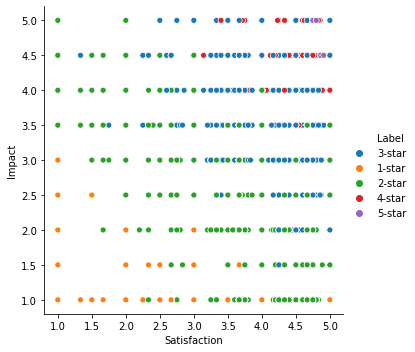

In [74]:
sns.relplot(x='Satisfaction', y='Impact',hue='Label',data=segment)

In [75]:
star=amazon[amazon['reviewerID'] =='ADGWCHCYTVMYE']
star['reviewerName']

2688    A. Bell
Name: reviewerName, dtype: object

In [76]:
segment.to_csv('/Users/abc/Desktop/Takeaway.com/Prepare for Tableau/segment_clustering.csv', index=True, header=True)

## Further analysis can be

#### Recommendation - Part 1 Popularity Based Recommendation Model


Being popularity based recommender model, we have got the same result for all users i.e. the model is recommending same products for all the users.


#### Recommendation - Part 2 Collaborative Filtering Recommendation Model

-Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.

-A model based collaborative filtering technique is closen here as it helps in making predictinfg products for a particular user by identifying patterns based on preferences from multiple user data.